In [2]:
#! usr/bin/env python3

import cv2
import pytesseract
from matplotlib import pyplot as plt

In [3]:
image_path = 'Reciepts/20240121_123406.jpg'
# image_path = 'Reciepts/Screenshot_20240119_144636_Snapchat.jpg'
image = cv2.imread(image_path)

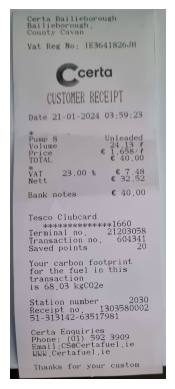

In [4]:
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

In [5]:
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# plt.imshow(image)
# plt.axis('off')  # Hide the axis
# plt.show()

In [6]:
# image = cv2.bitwise_not(image)
# plt.imshow(image)
# plt.axis('off')  # Hide the axis
# plt.show()

In [7]:
# image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# plt.imshow(image)
# plt.axis('off')  # Hide the axis
# # plt.show()

In [8]:
text = pytesseract.image_to_string(image)

In [9]:
filtered_text = '\n'.join(
    line for line in text.split('\n') if line.strip() != '')

print(filtered_text)

Certa Bailieborough
Railieborough,
County Cavan
Vat Reg No; I[E3641826J1
Ccerta
CUSTONER RECEIPT
Date 2)-01-2024 03;59;25
+ :
Pump 8 Unleaded
Volume 24.13 °¢
Price © 1,696/¢
TOTAL € 40,00
*
VAT 23.00 4% € 7.48
Nett € 32.52
Bank notes € 40 ,00
Tesco Clubcard
SOR RRR 1 66 0
Terminal no, 21203058
Transaction no, 604341
Saved points 5
Your carbon footprint
for the fuel in this
transaction
is 68.03 kgCOZe
Station number 2030
Receipt no, 1303580002
51-313142-63517981
Certa Enquiries
Phone: (01) 592 3909
Email :-CS@eCertafuel ,ie
WWW Certafuel ,ie
Thanks for your custom


NameError: name 'total_fuel_price' is not defined